In [1]:
import os
import copy

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from tqdm.auto import tqdm
from scipy.stats import linregress

In [2]:
f = FAIR()

In [3]:
f.define_time(1850, 2050, 1)

In [4]:
scenarios = ['esm-bell-750PgC', 'esm-bell-1000PgC', 'esm-bell-2000PgC']

In [5]:
# do one at a time
#scenarios = [scenarios[0]]
f.define_scenarios(scenarios)
fair_params_df = pd.read_csv('../data/fair2.1-parameters/calibration-1.4.0/calibrated_constrained_parameters.csv', index_col=0)

In [6]:
f.define_configs(list(fair_params_df.index))

In [7]:
species = ['CO2', 'CH4', 'N2O']
properties = {
    "CO2": {
        'type': 'co2',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    },
    "CH4": {
        'type': 'ch4',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    },
    "N2O": {
        'type': 'n2o',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    }
}

In [8]:
# declare species and properties
f.define_species(species, properties)

In [9]:
f.allocate()

In [10]:
f.fill_from_rcmip()

In [11]:
f.concentration.loc[dict(specie='CH4')] = 808.2490285
f.concentration.loc[dict(specie='N2O')] = 273.021047

In [12]:
# Get default species configs
f.fill_species_configs()

# Climate response
fill(f.climate_configs['ocean_heat_capacity'], fair_params_df.loc[:,'clim_c1':'clim_c3'])
fill(f.climate_configs['ocean_heat_transfer'], fair_params_df.loc[:,'clim_kappa1':'clim_kappa3'])
fill(f.climate_configs['deep_ocean_efficacy'], fair_params_df.loc[:,'clim_epsilon'])
fill(f.climate_configs['gamma_autocorrelation'], fair_params_df.loc[:,'clim_gamma'])
fill(f.climate_configs['stochastic_run'], False)

# carbon cycle
fill(f.species_configs['iirf_0'], fair_params_df.loc[:, 'cc_r0'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_airborne'], fair_params_df.loc[:, 'cc_rA'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_uptake'], fair_params_df.loc[:, 'cc_rU'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_temperature'], fair_params_df.loc[:, 'cc_rT'].values.squeeze(), specie='CO2')

# Scale CO2 forcing based on its 4xCO2 calibration
fill(f.species_configs["forcing_scale"], fair_params_df["fscale_CO2"].values.squeeze(), specie='CO2')

# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(f.species_configs['baseline_concentration'], 284.3169988, specie='CO2')
fill(f.species_configs['baseline_concentration'], 808.2490285, specie='CH4')
fill(f.species_configs['baseline_concentration'], 273.021047, specie='N2O')

In [13]:
fill(f.species_configs['forcing_reference_concentration'], 284.3169988, specie='CO2')
fill(f.species_configs['forcing_reference_concentration'], 808.2490285, specie='CH4')
fill(f.species_configs['forcing_reference_concentration'], 273.021047, specie='N2O')

In [14]:
f.species_configs

<xarray.Dataset>
Dimensions:                                   (config: 841, specie: 3, gasbox: 4)
Coordinates:
  * config                                    (config) int64 1439 ... 1597514
  * specie                                    (specie) <U3 'CO2' 'CH4' 'N2O'
  * gasbox                                    (gasbox) int64 0 1 2 3
Data variables: (12/31)
    tropospheric_adjustment                   (config, specie) float64 0.05 ....
    forcing_efficacy                          (config, specie) float64 1.0 .....
    forcing_temperature_feedback              (config, specie) float64 0.0 .....
    forcing_scale                             (config, specie) float64 0.9587...
    partition_fraction                        (config, specie, gasbox) float64 ...
    unperturbed_lifetime                      (config, specie, gasbox) float64 ...
    ...                                        ...
    aci_shape                                 (config, specie) float64 0.0 .....
    cl_atoms                                  (specie) float64 0.0 0.0 0.0
    br_atoms                                  (specie) float64 0.0 0.0 0.0
    fractional_release                        (config, specie) float64 0.0 .....
    ch4_lifetime_chemical_sensitivity         (config, specie) float64 0.0 .....
    lifetime_temperature_sensitivity          (config) float64 -0.0408 ... -0...

In [15]:
# set initial conditions
initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.airborne_emissions, 0)
initialise(f.cumulative_emissions, 0)

In [16]:
f.run()

Running 2523 projections in parallel:   0%|          | 0/200 [00:00<?, ?timesteps/s]

In [17]:
f.forcing

<xarray.DataArray (timebounds: 201, scenario: 3, config: 841, specie: 3)>
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
...
         ...,
         [1.61124704e+00, 0.00000000e+00, 0.00000000e+00],
         [1.95154774e+00, 0.00000000e+00, 0.00000000e+00],
         [1.60296952e+00, 0.00000000e+00, 0.00000000e+00]],

        [[2.40598867e+00, 0.00000000e+00, 0.00000000e+00],
         [2.41802872e+00, 0.00000000e+00, 0.00000000e+00],
         [2.23945936e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [2.08671077e+00, 0.00000000e+00, 0.00000000e+00],
         [2.58840321e+00, 0.00000000e+00, 0.00000000e+00],
         [2.02772618e+00, 0.00000000e+00, 0.00000000e+00]],

        [[4.91698466e+00, 0.00000000e+00, 0.00000000e+00],
         [5.08370079e+00, 0.00000000e+00, 0.00000000e+00],
         [4.43920808e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [3.80522981e+00, 0.00000000e+00, 0.00000000e+00],
         [5.03235246e+00, 0.00000000e+00, 0.00000000e+00],
         [3.42477823e+00, 0.00000000e+00, 0.00000000e+00]]]])
Coordinates:
  * timebounds  (timebounds) float64 1.85e+03 1.851e+03 ... 2.049e+03 2.05e+03
  * scenario    (scenario) <U16 'esm-bell-750PgC' ... 'esm-bell-2000PgC'
  * config      (config) int64 1439 2367 2658 2806 ... 1595217 1595502 1597514
  * specie      (specie) <U3 'CO2' 'CH4' 'N2O'

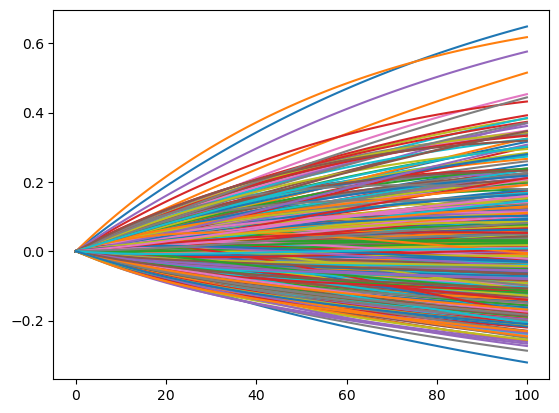

In [18]:
pl.plot(f.temperature[100:,0,:,0] - f.temperature[100,0,:,0]);

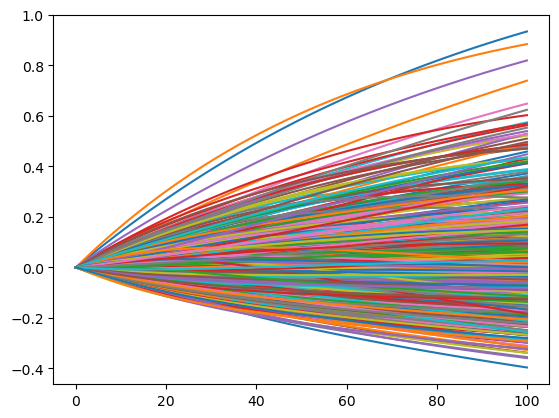

In [19]:
pl.plot(f.temperature[100:,1,:,0] - f.temperature[100,1,:,0]);

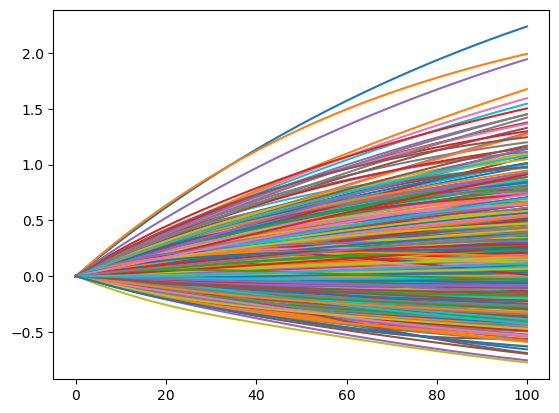

In [20]:
pl.plot(f.temperature[100:,2,:,0] - f.temperature[100,2,:,0]);

[-0.12089081 -0.02922349  0.15031888]
[-0.14860218 -0.02858559  0.21768609]
[-0.24636956  0.02592987  0.54865576]


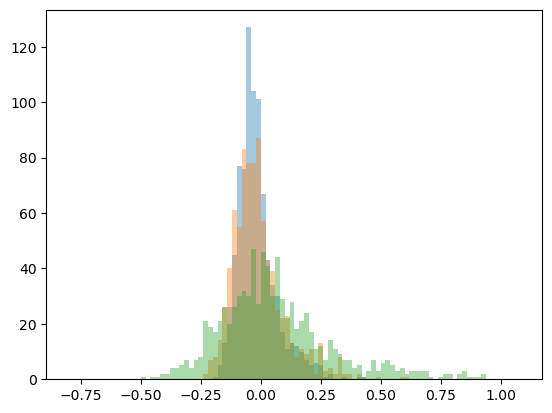

In [21]:
# ZEC50
pl.hist(f.temperature[150,0,:,0] - f.temperature[100,0,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
pl.hist(f.temperature[150,1,:,0] - f.temperature[100,1,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
pl.hist(f.temperature[150,2,:,0] - f.temperature[100,2,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
print(np.percentile(f.temperature[150,0,:,0] - f.temperature[100,0,:,0], (5,50,95)))
print(np.percentile(f.temperature[150,1,:,0] - f.temperature[100,1,:,0], (5,50,95)))
print(np.percentile(f.temperature[150,2,:,0] - f.temperature[100,2,:,0], (5,50,95)))

[-0.18809123 -0.04317481  0.23602102]
[-0.22947664 -0.03194407  0.34917261]
[-0.40653574  0.04511463  0.890717  ]


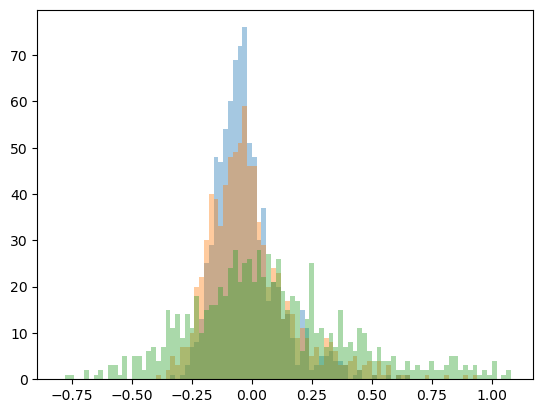

In [22]:
# ZEC100
pl.hist(f.temperature[200,0,:,0] - f.temperature[100,0,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
pl.hist(f.temperature[200,1,:,0] - f.temperature[100,1,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
pl.hist(f.temperature[200,2,:,0] - f.temperature[100,2,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
print(np.percentile(f.temperature[200,0,:,0] - f.temperature[100,0,:,0], (5,50,95)))
print(np.percentile(f.temperature[200,1,:,0] - f.temperature[100,1,:,0], (5,50,95)))
print(np.percentile(f.temperature[200,2,:,0] - f.temperature[100,2,:,0], (5,50,95)))

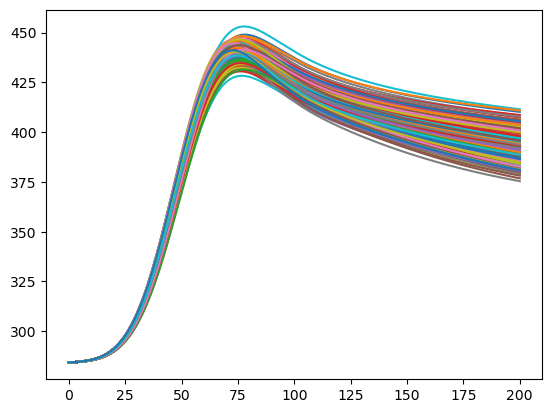

In [23]:
pl.plot(f.concentration[:,0,:,0]);

In [24]:
f.temperature[150,0,12,0] - f.temperature[100,0,12,0]

<xarray.DataArray ()>
array(-0.08611114)
Coordinates:
    scenario  <U16 'esm-bell-750PgC'
    config    int64 22297
    layer     int64 0

In [25]:
f.temperature[150,0,:,0] - f.temperature[100,0,:,0]

<xarray.DataArray (config: 841)>
array([-3.02180507e-03, -2.76445349e-02, -5.42190312e-02, -2.03104355e-02,
       -3.66431508e-02,  6.73023957e-02,  2.77942737e-02, -5.24902439e-02,
       -3.94778595e-02, -1.03172637e-01, -2.24956447e-02, -5.48688994e-02,
       -8.61111376e-02, -1.81199359e-02, -4.10438854e-02, -8.14881025e-02,
        3.59949519e-02,  2.30896509e-02,  7.86340131e-02, -1.09032199e-01,
        4.09316800e-01, -8.52851347e-02, -5.87688831e-02, -9.72114438e-02,
       -6.93231662e-02, -5.50533125e-02, -5.12441654e-02, -1.79568618e-02,
       -5.94141568e-02, -1.90253974e-02, -9.13776353e-02, -9.51823850e-02,
       -1.75630880e-02, -1.33040250e-01, -1.88949205e-02, -5.66063241e-02,
       -7.49411718e-02,  2.95418675e-02, -4.88282696e-02, -1.58170189e-02,
       -9.78835332e-02, -6.60753643e-02,  8.63164580e-03,  1.28697949e-01,
       -9.80080580e-02,  5.53968521e-02, -7.90827012e-03, -2.14584479e-02,
       -4.05352390e-03,  1.15088016e-02, -1.26122857e-01,  4.45536492e-02,
       -8.34586930e-02, -5.32448538e-02,  2.03425058e-02, -2.73819594e-02,
       -4.28463865e-02, -9.91175821e-02, -1.01306711e-01, -6.18423003e-02,
       -1.17962301e-01, -1.15820563e-01,  1.31945500e-01,  3.23190895e-02,
       -9.53072069e-02, -9.89462225e-03,  2.60023589e-01, -6.89065115e-02,
        2.40086677e-01,  1.33180144e-02, -2.10165666e-02,  4.32896750e-01,
       -9.76079201e-02, -1.57036187e-01, -1.11487762e-01,  4.96587365e-02,
       -4.87799053e-02, -1.66720123e-02, -1.09969538e-01, -3.77949710e-02,
...
        3.56279436e-01, -1.20611829e-01, -9.97781510e-02,  1.78139896e-01,
        8.78162384e-03, -8.32487462e-02, -5.83800374e-02, -1.56999534e-01,
       -9.85637349e-02,  9.74391856e-02, -3.11831540e-02, -3.93568866e-02,
       -1.05368162e-02, -2.74677847e-02, -5.01979623e-03, -6.25581264e-02,
       -5.27366405e-02,  4.98127114e-02,  5.38396664e-02,  4.52394037e-02,
       -3.59712238e-02, -5.73983757e-02,  8.51463260e-02, -1.03675050e-01,
        2.01729446e-01, -1.03547535e-01, -1.30673097e-02,  6.77486971e-03,
        2.93046867e-02,  1.01061120e-02, -4.15800890e-02, -2.18095154e-02,
       -3.76989820e-04, -4.57947301e-02, -2.23355064e-02,  6.89832872e-02,
       -4.37983710e-02,  1.21168195e-01,  1.08388282e-02, -4.47253993e-02,
        1.48726623e-01,  1.91523521e-01,  1.97007578e-02,  2.45179653e-01,
       -1.23730821e-02, -3.87414411e-02, -1.42288288e-02,  7.22951081e-02,
        2.21726401e-02, -1.32597510e-02, -3.52243483e-03,  2.37287889e-01,
        5.22709619e-02, -5.59018339e-02, -3.22748734e-02, -6.14073731e-02,
        7.52081456e-02,  4.72954012e-02, -7.80261025e-02, -8.69536476e-02,
       -5.33380637e-02, -4.05222627e-02, -1.03147159e-01, -1.19024196e-01,
        6.26236612e-02,  1.82598402e-01,  3.35352976e-03, -1.07952581e-01,
       -5.62997113e-02,  4.69388535e-02, -5.83172123e-02, -7.66764842e-02,
        8.27397247e-02,  3.72600986e-02, -1.39931668e-01, -1.34184282e-03,
       -1.42158927e-01])
Coordinates:
    scenario  <U16 'esm-bell-750PgC'
  * config    (config) int64 1439 2367 2658 2806 ... 1595217 1595502 1597514
    layer     int64 0

In [26]:
df = pd.DataFrame(
    np.array([
        f.temperature[148,0,:,0] - f.temperature[100,0,:,0], 
        f.temperature[150,0,:,0] - f.temperature[100,0,:,0], 
        f.temperature[200,0,:,0] - f.temperature[100,0,:,0],
        f.temperature[150,1,:,0] - f.temperature[100,1,:,0], 
        f.temperature[200,1,:,0] - f.temperature[100,1,:,0],
    ]).T,
    index=fair_params_df.index, 
    columns=['zec48_750', 'zec50_750', 'zec100_750', 'zec50_1000', 'zec100_1000']
)

In [27]:
os.makedirs('../results/', exist_ok=True)
df.to_csv('../results/zec_esm-bell_cal-1.4.0.csv')